# Background:

What Dietterich covers:
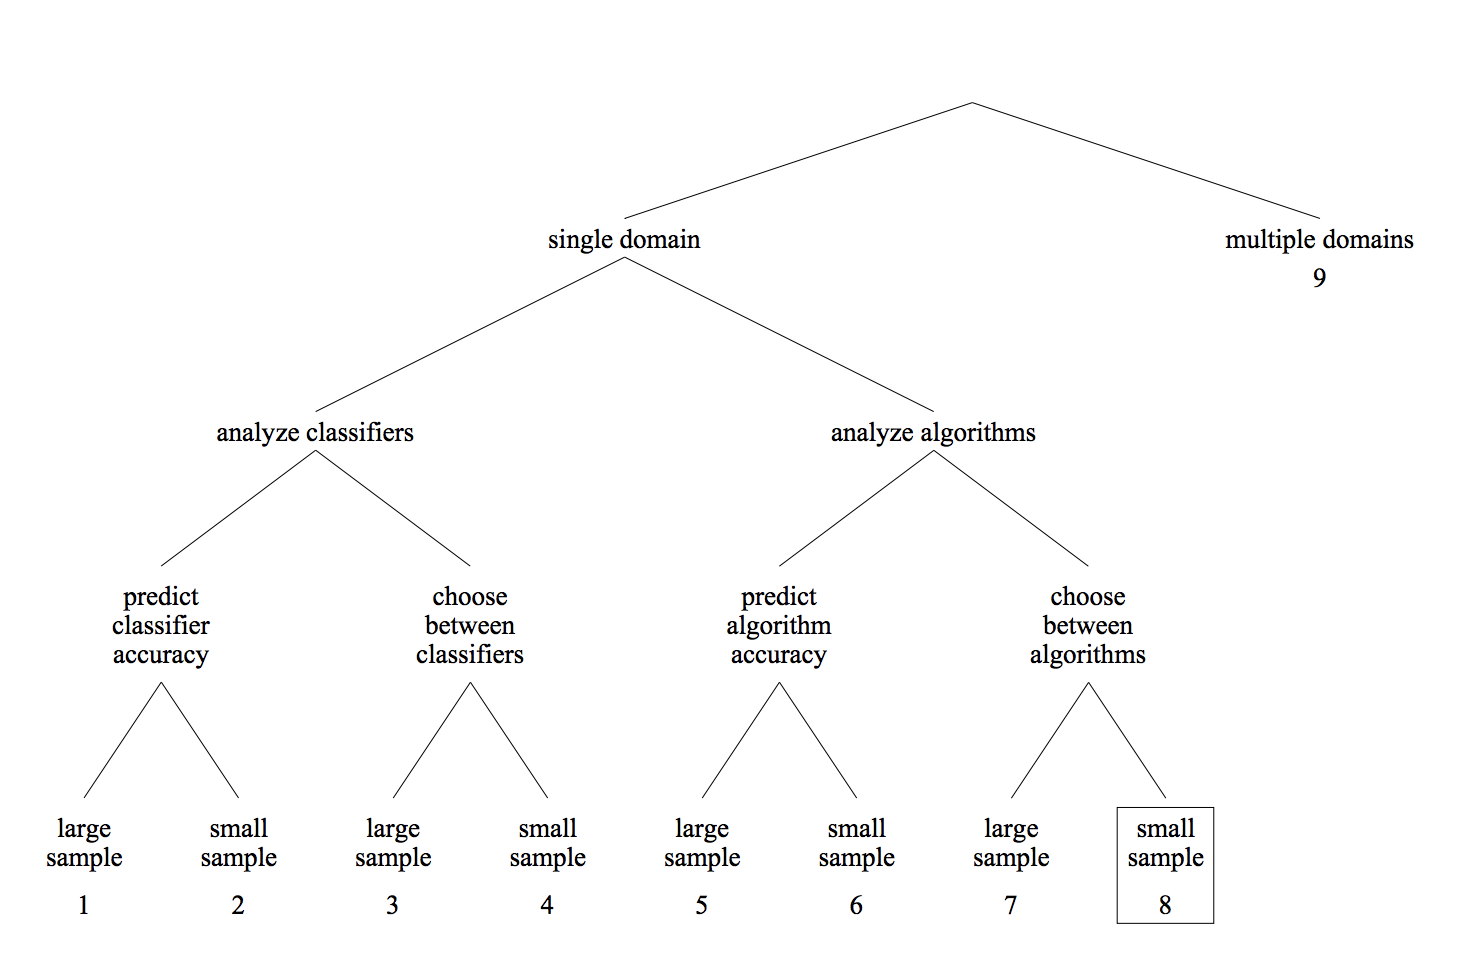

The problem can be stated as:

>Given two learning algorithms A and B and a small data set S, which algorithm will produce more accurate classifiers when trained on data sets of the same size as S? The purpose of this paper is to describe and compare several statistical tests for answering this question. Because S is small, it will be necessary to use holdout and resampling methods. This means that we cannot answer this question exactly without making the assumption that the performance of the two learning algorithms changes smoothly with changes in the size of the training set. Specifically, we will need to assume that the relative difference in performance of the two algorithms changes slowly with changes in the size of the training set.

To design and evaluate statistical tests, there are four sources of variation to consider:
 - The random selection of test data
 - The random selection of training data
 - Internal randomness in the learning algorithm (e.g. starting point of a NN)
 - Labelling errors in the data

A good statistical test should be able to correctly decide if there is a statistical significance between two classifiers even with these sources of variation by accounting for each one in various ways

The 5 tests:
Shared ideas:
Important to remember: We are examining algorithms that produce classifiers, not the classifiers themselves
All of the data can be placed on this table, and we will refer to it when discussing the following tests by n00, n01, n10, n11, the number of samples that fall in each category

|  | $C_a$ misclassified example | $C_a$ classified example correctly |
|---|---|---|
| $C_b$ misclassified example | Both incorrect (n00) | $C_a$ correct, $C_b$ incorrect (n10) |
| $C_b$ classified example correctly | $C_a$ incorrect, $C_b$ correct (n01) | Both correct (n11) |


## McNemar’s test:
McNemar’s test focuses on comparing the observed error rates of two algorithms A and B to the expected error rates under the null hypothesis. It does this by using a chi-squared test for goodness of fit on data in the test set which the algorithms return different results (n01, n10).

There is more detail in how the McNemar’s statistic is constructed, and I need to do more research into this.

#### Drawbacks:
McNemar’s test does not account for variability due to the choice of training set or algorithm randomness, nor does it compare the algorithms on training sets of size S, only on sets of size R.

#### Questions:
Why not run the algorithm on a cross validated set to get rid of the first weakness?

## Difference of two proportions:
This test focuses on the error rates of each algorithm (pA = (n00 + n01)/n, pB = (n00 + n10)/n)
These probabilities form a binomial distribution, which the paper claims can be reasonably approximated by a normal distribution. By taking the difference of these distributions (resulting in another normal distribution) under the null hypothesis we get a normal distribution centered around 0. By normalizing this statistic formed by this analysis, we then get a z-score which can be used to refute the null hypothesis

#### Drawbacks:
This test assumes that pA and pB are independent (otherwise pA - pB will not necessarily be normal). Since these probabilities are measured on the same test set, they are not independent. Additionally, this test has the same issues as McNemar’s test since it is also taken on one set of data that is smaller than the true set.

One way to tackle the issue of pA and pB not being independent is by using a different measurement for the standard error that we use to normalize the statistic. Making this adjustment, we find that our statistic is the same as the square root of the McNemar’s statistic (cool!). We do not take this approach however since it would be redundant and it is more useful to look at the uncorrected value, which was sadly in use when the paper was written (how about now?)

## Resampled Paired t test:
This test is mostly described by its name: each algorithm is resampled on a randomly selected split of training and test data, resulting in n different pA and pB values. The difference of these values are then used as the population in a paired t-test.

#### Drawbacks:
this test assumes that the difference of pA and pB will be normally distributed when it is not (similar to the difference of two proportions test). This is due to pA and pB not being independent because they are run on the same data, as well as the separate tests not being independent because they overlap on the same test data.

## K-fold cross-validated paired t-test:
This test is identical to above, except it removed the second part of the independence issue by ensuring the test data is independent. It does this by separating the data into k sets, then running k trials in which the test data is one of the k sets and the training data is the rest of the data.

#### Drawbacks:
This test still suffers from an underestimation of the true variation of the data since the majority of the training data is shared across each trial. There is a good example of the issues inherent to this test in the paper at the end of page 9.

## 5x2cv paired t-test:
5x2cv is a test that the author has devised that does five rounds of cross validations with a 50/50 train-test split. The author derived why this method is effective in his paper, but the main point is that it makes looser assumptions that tend to hold better in real life data.

# Part 1:

## Simulation Experiment Design:

The paper now discusses the simulations the author ran to examine each of the five methods. The paper is mostly focused on type I error (incorrect rejection of the null hypothesis).

#### Simulated learning algorithms:
To start, the author simulated the behavior of learning algorithms instead of using actual algorithms in order to get “worst case” behavior for the statistical tests to measure.

This test did not simulate the issue of overlap in training sets, but still yielded interesting (and, due to ignoring the overlap, optimistic) results. Very quickly it becomes apparent that the resampled t-test is inadequate, even in this optimistic setting. The two proportion test also exceeded the acceptable type I error rate of 0.05, but by significantly less than the resampled t test. Interestingly enough, the more splits run for the resampled t test the greater the probability of type I error.

The overarching issue of the two failing tests is that when the split of data is not perfectly representative of the population, the observed differences between the algorithms is large. The key reason McNemar’s test does not succumb to the same issue is that it looks at the cases when the two classifiers disagree while the other two tests look at the overall probability of errors. If the probability of errors is high, this can lead to significant issues for the two failing tests since they ignore the agreement between the classifiers and simply look at the difference in error rates, which can be misleading.

Because of its high error rate and computational cost, the author discards the resampled t-test

#### Target result

We aim to reproduce this graph using the methods outlined in the paper:
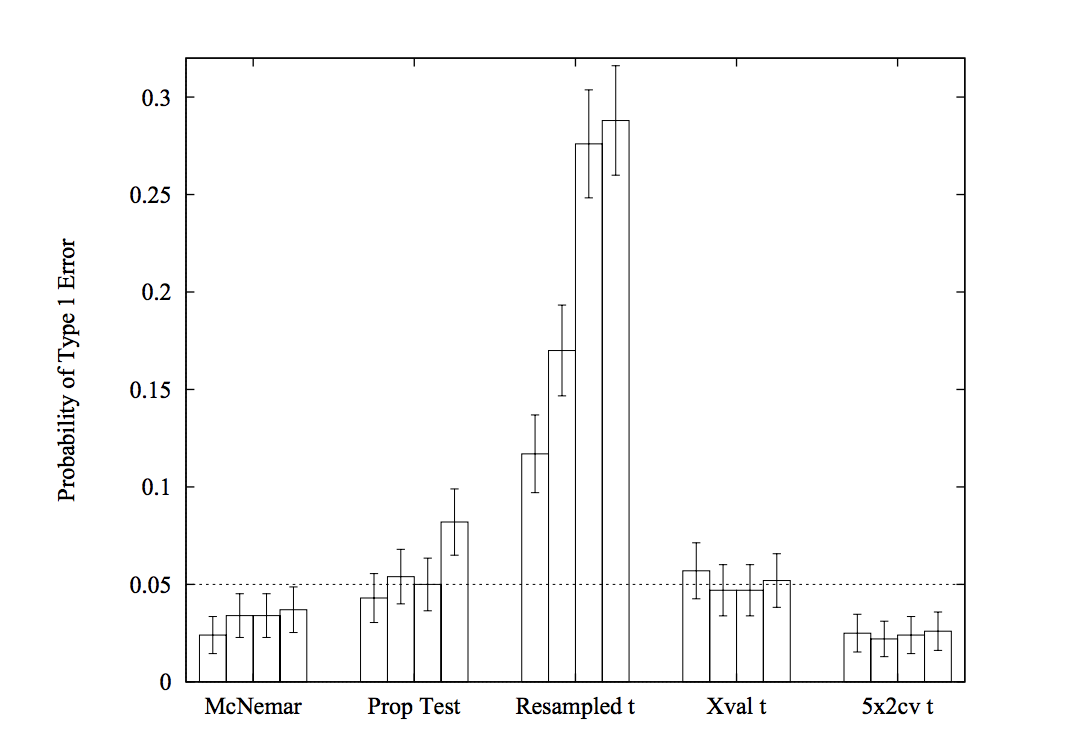

For now I am skipping teaching-level explanations of the problem in favor of getting the correct results faster.

Dietterich sought to maximize the error from training and test set selection with simulated classification algorithms, which he identified as the primary source of error.

In order to do this, they set a target error rate $\epsilon$ then created two artificial classifiers (we'll call them $C_A$ and $C_B$) where for the first half of the data, $C_A$ has a classification error rate of $\frac{3}{2}\epsilon$ and $C_B$ has a classification error rate of $\frac{1}{2}\epsilon$. Then, for the second half of the data, the error rates were reversed. We will use $\epsilon = 0.10$ .

Each experiment consisted of 1000 trials, with each dataset containing 300 data points drawn with replacement (meaning each data point independently had a 50/50 chance of being in the first group or the second group).

* For the first two tests (McNemar's and the normal test for the difference of two populations), the dataset was divided into 2/3rds training and 1/3rd test data. The training data was ignored and the tests were run using our artificial classifiers.
* The resampled paired t-test was split (as previously described) and run 30 times.
* For the k-fold cross validation, the dataset was split into 10 random subsets and classified as described above, with a $\beta$ between \[-0.02 and +0.02\] added on to $\epsilon$ for each set to simulate the difference in quality of training sets.
* For the 5x2cv test, the tests were performed as described above.

It is important to note that this test did not simulate the issue of overlap in training sets.

In [130]:
import random
import math

# Generates fake classification results
# we want A to classify poorly in the first population and well in the second, and B to be the exact opposite.

CHI_SQUARED_95PCT = 3.841
NORMAL_975PCT = 1.96
T_29_975PCT = 2.045
T_9_975PCT = 2.262
T_5_975PCT = 2.571

def draw_sample(class_vec, ratio = 0.333):
    return random.sample(class_vec, int(len(class_vec) * ratio))

def split_sample(class_vec, n_folds):
    size = int(len(class_vec) / n_folds)
    return [class_vec[i:i + size] for i in range(0, len(class_vec), size)]

# Not quite mean square variance, as we are dividing by n - 1.
# TODO: figure out exactly what this is.
def mean_squared_variance(p_vec, p):
    return sum((p_i - p) ** 2 for p_i in p_vec) / (len(p_vec) - 1)

def generate_classifications(n = 300, epsilon = 0.1, first_pop_pct = 0.5):
    results = [] # array of tuples of bools (a_was_correct, b_was_correct)
    for i in range(n):
         # True -> we land in the first population, False -> the second
        population = i < (n * first_pop_pct)
        
        a_was_correct = random.random() > ( epsilon * ( 0.5 if population else 1.5 ) )
        b_was_correct = random.random() > ( epsilon * ( 0.5 if not population else 1.5 ) )
        results.append((a_was_correct, b_was_correct))
        
    random.shuffle(results)
    return results

def calc_p(test_sample):
    num_samples = len(test_sample)
    pa = sum(not a for (a,b) in test_sample) / num_samples
    pb = sum(not b for (a,b) in test_sample) / num_samples
    return pa, pb

def calc_McNemars_statistic(class_vec):
    test_sample = draw_sample(class_vec)
    n10 = test_sample.count((True, False))
    n01 = test_sample.count((False, True))
    total_differences = n01 + n10
    
    # ((|n01 - n10| - 1)^2) / (n01 + n10)
    return ((math.fabs(n01 - n10) - 1) ** 2) / total_differences

def calc_diff_proportions_statistic(class_vec):
    test_sample = draw_sample(class_vec)
    pa, pb = calc_p(test_sample)
    p = (pa + pb) / 2
    
    #(|pa - pb|) / sqrt(2p(1-p)/n)
    return math.fabs(pa - pb) / math.sqrt((2 * p * (1 - p)) / len(test_sample))

def calc_resampled_paired_t_test_statistic(class_vec, n=30):
    
    p_vec = [pa - pb for (pa, pb) in # calculate difference of error rates
                [calc_p(draw_sample(class_vec)) for _ in range(n)]] # draw n samples
    
    p = sum(p_vec) / n # calculate mean error rate

    #(p * sqrt(n)) / sqrt((sum from 0 to n of (p_i - p)^2) / (n-1))    
    return (p * math.sqrt(n)) / math.sqrt(mean_squared_variance(p_vec, p))

def calc_cross_validation_statistic(class_vec, n_folds=10):
    # note that in the study, they add a beta [-0.02, +0.02] to error rates of
    # each fold. We are not doing this because a) it seems to not make a large
    # difference and b) I believe it is incorrect (discuss with prof)
    
    # split the data into n folds
    test_sample = split_sample(class_vec, n_folds)
    
    p_vec = [pa - pb for (pa, pb) in # calculate difference of error rates
             [calc_p(s) for s in test_sample]] # for each fold
    
    p = sum(p_vec) / n_folds # calculate mean error rate

    #(p * sqrt(n)) / sqrt((sum from 0 to n of (p_i - p)^2) / (n-1))    
    return (p * math.sqrt(n_folds)) / math.sqrt(mean_squared_variance(p_vec, p))

def calc_replicated_cross_valication_statistic(class_vec, n_replications=5, n_folds = 2):
    # note that we are using the final p1 instead of the first (which is used in the paper)
    # This is for programming simplicity's sake, since they should be indistinguishable
    p_vec = []
    s_vec = []
    
    for _ in range(n_replications):
        test_sample = split_sample(class_vec, n_folds)
        
        p_vec = [pa - pb for (pa, pb) in # calculate difference of error rates
                 [calc_p(s) for s in test_sample]] # for each fold
        
        s_vec.append(mean_squared_variance(p_vec, sum(p_vec) / n_folds))
        
        random.shuffle(class_vec) # so that we get another random split

    # p1_5 / sqrt(sum from 0 to n of s^2)
    # where p1_5 is the 5th p1
    #print(s_vec)
    return p_vec[0] / math.sqrt(sum(s_vec) / len(s_vec))

def run_trials():
    num_trials = 1000
    tests = ["McNemar's",
             "Difference of Proportions",
             "Resampled Paired t-test",
             "k-fold Cross Validation",
             "5x2cv t-test"]
    significant_result_count = [0] * len(tests)
    
    for trial in range(num_trials):
        classifications = generate_classifications()
        significant_result_count[0] += calc_McNemars_statistic(classifications) > CHI_SQUARED_95PCT
        significant_result_count[1] += calc_diff_proportions_statistic(classifications) > NORMAL_975PCT
        significant_result_count[2] += calc_resampled_paired_t_test_statistic(classifications) > T_29_975PCT
        significant_result_count[3] += calc_cross_validation_statistic(classifications) > T_9_975PCT
        significant_result_count[4] += calc_replicated_cross_valication_statistic(classifications) > T_5_975PCT
        
    for i in range(len(tests)):
        print(tests[i] + ": " + str(significant_result_count[i] / num_trials))

#print(calc_resampled_paired_t_test(generate_classifications()))
run_trials()

#calc_cross_validation_statistic(generate_classifications())

McNemar's: 0.024
Difference of Proportions: 0.064
Resampled Paired t-test: 0.338
k-fold Cross Validation: 0.027
5x2cv t-test: 0.012
